In [21]:
import os
import time
import numpy as np
import pandas as pd
import openml
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import StatevectorSampler, Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient, SPSASamplerGradient
from qiskit.transpiler import PassManager

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Data

In [22]:
def get_data(openml_dataset_id):
    try:
        dataset = openml.datasets.get_dataset(openml_dataset_id)
        print(f"Dataset name: {dataset.name}")
    except Exception as e:
        print(f"Error fetching dataset {openml_dataset_id}: {e}")
        return None
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    X = pd.get_dummies(X)
    le = LabelEncoder()
    y = le.fit_transform(y)
    return X, y, le

def process_data(X, y):
    """Clean data: drop NaNs, duplicates, constant columns, and remove categoricals.
    Assumes X is DataFrame, y is ndarray."""
    y = pd.Series(y, index=X.index)

    total_features = X.shape[1]
    num_categoricals = X.select_dtypes(exclude=["number"]).shape[1]

    X = X.dropna()
    y = y.loc[X.index]

    X = X.drop_duplicates()
    y = y.loc[X.index]

    X = X.select_dtypes(include=["number"]) # dropping categorical features currently

    remaining_features = X.shape[1]

    print(f"Total features: {total_features}, Dropped Categorical features: {num_categoricals}, Remaining features: {remaining_features}")

    return pd.DataFrame(X), y.to_numpy()


def scale_data_classical(x_train, x_val, x_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    return x_train, x_val, x_test

def scale_data_quantum(x_train, x_val, x_test):
    # scaler = MinMaxScaler() # MinMaxScaler(feature_range=(0, np.pi))
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    return x_train, x_val, x_test

def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def create_data_splits(X, y, batch_size=32, is_classical=True, do_pca=False, n_components=2):

    is_multiclass = len(np.unique(y)) > 2

    if do_pca:
        X = apply_pca(X, n_components=n_components)
        print(f"{'Classical' if is_classical else 'Quantum'} data reduced to {X.shape[1]} dimensions using PCA.")

    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y) # 60/20/20
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    if is_classical:
        x_train, x_val, x_test = scale_data_classical(x_train, x_val, x_test)
    else:
        x_train, x_val, x_test = scale_data_quantum(x_train, x_val, x_test)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size)

    input_dim = x_train.shape[1]
    output_dim = len(np.unique(y))

    return x_train, x_val, x_test, y_train, y_val, y_test, train_loader, val_loader, test_loader, input_dim, output_dim, is_multiclass

In [23]:
def data_pipeline(openml_dataset_id, batch_size=32, do_pca=False, n_components=2):
    X, y, le = get_data(openml_dataset_id)
    if X is None:
        raise ValueError("Failed to fetch data. Exiting.")

    X, y = process_data(X, y)

    # --- Classical ---
    (
        x_train_c,
        x_val_c,
        x_test_c,
        y_train_c,
        y_val_c,
        y_test_c,
        train_loader_c,
        val_loader_c,
        test_loader_c,
        input_dim,
        output_dim,
        is_multiclass,
    ) = create_data_splits(X, y, batch_size=batch_size, is_classical=True, do_pca=do_pca, n_components=n_components)

    # --- Quantum ---
    (
        x_train_q,
        x_val_q,
        x_test_q,
        y_train_q,
        y_val_q,
        y_test_q,
        train_loader_q,
        val_loader_q,
        test_loader_q,
        _,
        _,
        _,
    ) = create_data_splits(X, y, batch_size=batch_size, is_classical=False, do_pca=do_pca, n_components=n_components)
    classical_data = (
        x_train_c,
        x_val_c,
        x_test_c,
        y_train_c,
        y_val_c,
        y_test_c,
        train_loader_c,
        val_loader_c,
        test_loader_c,
    )
    quantum_data = (
        x_train_q,
        x_val_q,
        x_test_q,
        y_train_q,
        y_val_q,
        y_test_q,
        train_loader_q,
        val_loader_q,
        test_loader_q,
    )
    return classical_data, quantum_data, input_dim, output_dim, is_multiclass


In [24]:
def print_class_distribution(y_tensor, name):
    values, counts = torch.unique(y_tensor, return_counts=True)
    total = counts.sum().item()
    print(f"{name} class distribution:")
    for v, c in zip(values.tolist(), counts.tolist()):
        pct = 100 * c / total
        print(f"  Class {v}: {c} samples ({pct:.2f}%)")
    print()


In [25]:
def plot_classification_results(X, y_true, y_pred, 
                                cmap_name="tab10",
                                point_size=60,
                                mistake_size=200,
                                mistake_edgecolor="r"):
    """
    X         : array_like, shape (N,2) — 2D inputs
    y_true    : array_like, shape (N,)  — integer labels 0..(n_classes–1)
    y_pred    : array_like, shape (N,)  — integer labels 0..(n_classes–1)
    cmap_name : matplotlib colormap name for up to 10 classes (e.g. 'tab10','tab20')
    """
    X = np.asarray(X)
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    assert X.shape[0] == y_true.shape[0] == y_pred.shape[0]
    n_classes = len(np.unique(y_true))

    # discrete colormap with exactly n_classes entries
    cmap = plt.get_cmap(cmap_name, n_classes)

    fig, ax = plt.subplots(figsize=(6,6))
    # plot all points, color by true label
    sc = ax.scatter(X[:,0], X[:,1],
                    c=y_true,
                    cmap=cmap,
                    s=point_size,
                    edgecolors="k",
                    alpha=0.8)

    # highlight mistakes
    mask = (y_true != y_pred)
    if mask.any():
        ax.scatter(X[mask,0], X[mask,1],
                   s=mistake_size,
                   facecolors="none",
                   edgecolors=mistake_edgecolor,
                   linewidths=2,
                   label="misclassified")

    # optional legend / colorbar
    if n_classes <= 10:
        # show discrete legend
        handles, _ = sc.legend_elements(prop="colors")
        labels = list(range(n_classes))
        ax.legend(handles, labels, title="class")
    else:
        # fallback to continuous colorbar
        plt.colorbar(sc, ticks=range(n_classes), label="true class")

    ax.set_xlabel("x₀")
    ax.set_ylabel("x₁")
    ax.set_title(f"{n_classes}-class scatter (red holes = mistakes)")
    plt.show()




In [26]:
def results_exporter(model: nn.Module,
                     model_type: str = "quantum",
                     dataset_name: str = "iris",
                     batch_size: int = 32,
                     epochs: int = 10,
                     average_time_per_epoch: float = 0.0,
                     input_dim: int = 4, 
                     depth: int = 0,
                     num_classes: int = 3,
                     test_metrics: dict = None,
                     save_csv: str = "./results/baseline_results.csv"):

    if os.path.exists(save_csv):
        results_df = pd.read_csv(save_csv)
    else:
        results_df = pd.DataFrame(columns=[
            'datetime', 'model_type', 'dataset_name', 'batch_size', 'epochs',
            'average_time_per_epoch', 'input_dim', 'depth', 'num_classes',
            'train_acc', 'train_loss', 'val_acc', 'val_loss', 'test_acc', 'test_loss'
        ])
        results_df.to_csv(save_csv, index=False)
        return False
    
    match_idx = results_df[
        (results_df['model_type'] == model_type) &
        (results_df['dataset_name'] == dataset_name) &
        (results_df['batch_size'] == batch_size) &
        (results_df['epochs'] == epochs) &
        (results_df['input_dim'] == input_dim) &
        (results_df['depth'] == depth) &
        (results_df['num_classes'] == num_classes)
    ].index
    
    new_row = {
        'datetime': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        'model_type': model_type,
        'dataset_name': dataset_name,
        'batch_size': batch_size,
        'epochs': epochs,
        'average_time_per_epoch': round(average_time_per_epoch, 4),
        'input_dim': input_dim,
        'depth': depth if model_type == "quantum" else 0,
        'num_classes': num_classes,
        'train_acc': round(model.history['train_acc'][-1], 4) if hasattr(model, 'history') else None,
        'train_loss': round(model.history['train_loss'][-1], 4) if hasattr(model, 'history') else None,
        'val_acc': round(model.history['val_acc'][-1], 4) if hasattr(model, 'history') else None,
        'val_loss': round(model.history['val_loss'][-1], 4) if hasattr(model, 'history') else None,
        'test_acc': round(test_metrics['test_acc'], 4) if test_metrics else None,
        'test_loss': round(test_metrics['test_loss'], 4) if test_metrics else None,
    }

    # Overwrite or append
    if len(match_idx) > 0:
        results_df.loc[match_idx[0]] = new_row
    else:
        new_row_df = pd.DataFrame([new_row])
        results_df = pd.concat([results_df, new_row_df], ignore_index=True)

    # Save
    results_df.to_csv(save_csv, index=False)
    return True



# Classical Model

In [27]:
class ClassicalNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, is_multiclass):
        super().__init__()
        self.is_multiclass = is_multiclass
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.criterion = nn.CrossEntropyLoss()
        self.history = {           
            "train_loss": [],
            "val_loss":   [],
            "train_acc":  [],
            "val_acc":    []    
        }
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x) 

    def fit(self, train_loader, val_loader, epochs, optimizer, scheduler=None, verbose=True):
        for epoch in range(epochs):
            self.train()
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
            n_batches = len(train_loader)

            for i, (xb, yb) in enumerate(loop):
                optimizer.zero_grad()
                pred = self(xb)
                yb = yb.long().view(-1)
                loss = self.criterion(pred, yb)
                loss.backward()
                optimizer.step()

                postfix = {"batch_loss": f"{loss.item():.3f}"}

                if i == n_batches - 1:
                    train_loss, train_acc, *_ = self.evaluate(train_loader)
                    val_loss,   val_acc,   *_ = self.evaluate(val_loader)
                    if scheduler is not None:
                        scheduler.step(val_loss)
                    self.history["train_loss"].append(train_loss)
                    self.history["val_loss"].append(val_loss)
                    self.history["train_acc"].append(train_acc)
                    self.history["val_acc"].append(val_acc)
                    if verbose:
                        postfix.update({
                            "train_loss": f"{train_loss:.3f}",
                            "train_acc":  f"{train_acc:.3f}",
                            "val_loss":   f"{val_loss:.3f}",
                            "val_acc":    f"{val_acc:.3f}",
                        })

                loop.set_postfix(**postfix)

    @torch.no_grad()
    def evaluate(self, loader):
        self.eval()
        total_loss, correct, total = 0.0, 0, 0
        all_preds, all_targets = [], []

        for xb, yb in loader:
            logits = self(xb)
            yb = yb.long().view(-1)
            loss = self.criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)

            yhat = logits.argmax(dim=1)
            correct += (yhat == yb).sum().item()
            total += yb.size(0)

            all_preds.append(yhat.cpu())
            all_targets.append(yb.cpu())

        avg_loss = total_loss / total
        acc = correct / total

        y_pred = torch.cat(all_preds).numpy()
        y_true = torch.cat(all_targets).numpy()
        avg_mode = 'macro' if logits.size(1) > 2 else 'binary'
        precision = precision_score(y_true, y_pred, average=avg_mode, zero_division=0)
        recall    = recall_score(y_true, y_pred, average=avg_mode, zero_division=0)
        f1        = f1_score(y_true, y_pred, average=avg_mode, zero_division=0)

        acc = correct / total
        y_pred = torch.cat(all_preds).numpy()
        y_true = torch.cat(all_targets).numpy()
        avg_mode = 'macro' if self.is_multiclass else 'binary'
        precision = precision_score(y_true, y_pred, average=avg_mode, zero_division=0)
        recall = recall_score(y_true, y_pred, average=avg_mode, zero_division=0)
        f1 = f1_score(y_true, y_pred, average=avg_mode, zero_division=0)

        return total_loss / total, acc, precision, recall, f1, y_pred, y_true
    
    # @staticmethod 
    # def get_weights_and_biases(model):
    #     weights_and_biases = {}
    #     for name, module in model.named_modules():
    #         if isinstance(module, torch.nn.Linear):
    #             weights_and_biases[f"{name}.weight"] = module.weight.detach().cpu()
    #             weights_and_biases[f"{name}.bias"] = module.bias.detach().cpu()
    #     return weights_and_biases

    def plot_history(self):
        """Plot training and validation loss curves."""
        epochs = range(1, len(self.history["train_loss"]) + 1)
        
        # Create loss plot
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, self.history["train_loss"], 'b-', label="Train")
        plt.plot(epochs, self.history["val_loss"], 'r-', label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (NLL)")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Quantum Model

In [28]:
class SamplerQNNTorchModel(nn.Module):
    def __init__(self, n_qubits, depth, num_classes=2):
        super().__init__()
        self.is_multiclass = num_classes > 2
        self.n_qubits = n_qubits
        self.num_classes = num_classes
        self.depth = depth
        self.model = None
        self.criterion = nn.NLLLoss()
        self.history = {           
            "train_loss": [],
            "val_loss":   [],
            "train_acc":  [],
            "val_acc":    []    
        }

        feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2)
        ansatz = TwoLocal(n_qubits, rotation_blocks=['ry','rz'], entanglement_blocks='cx',
                          entanglement='full', reps=depth)

        qc = QuantumCircuit(n_qubits)

        qc.compose(feature_map, inplace=True)
        qc.compose(ansatz, inplace=True)

        print(qc.decompose().draw(fold=-1))

        def interpret(x):
            return x % self.num_classes

        # sampler = StatevectorSampler() # for statevector simulation (exact, slow)
        sampler = Sampler(options={"shots": 1024}) # shots-based simulation (approximate, fast, but introduces sampling noise)
        gradient = ParamShiftSamplerGradient(sampler) # for param shift rule (exact, slow)
        # gradient = SPSASamplerGradient(sampler, epsilon=0.05) # stochastic, uses only 2 circuit evals (fast for many params), but needs careful tuning for epsilon and more epochs

        qnn = SamplerQNN(
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            interpret=interpret,
            output_shape=num_classes,
            sampler=sampler,
            gradient=gradient,
            pass_manager=PassManager()
        )

        initial_point = 0.1 * np.random.randn(len(ansatz.parameters))
        self.model = TorchConnector(qnn, initial_point)


    def forward(self, x):
        p = self.model(x)                      
        logits = torch.log(p + 1e-12)         
        return logits                        

    def fit(self, train_loader, val_loader, epochs, optimizer, scheduler=None, verbose=True):
        for epoch in range(epochs):
            self.train()
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
            n_batches = len(train_loader)

            for i, (xb, yb) in enumerate(loop):
                optimizer.zero_grad()
                pred = self(xb)
                loss = self.criterion(pred, yb)
                loss.backward()
                optimizer.step()

                postfix = {"batch_loss": f"{loss.item():.3f}"}

                if i == n_batches - 1:
                    train_loss, train_acc, *_ = self.evaluate(train_loader)
                    val_loss,   val_acc,   *_ = self.evaluate(val_loader)
                    if scheduler is not None:
                        scheduler.step(val_loss)
                    self.history["train_loss"].append(train_loss)
                    self.history["val_loss"].append(val_loss)
                    self.history["train_acc"].append(train_acc)
                    self.history["val_acc"].append(val_acc)
                    if verbose:
                        postfix.update({
                            "train_loss": f"{train_loss:.3f}",
                            "train_acc":  f"{train_acc:.3f}",
                            "val_loss":   f"{val_loss:.3f}",
                            "val_acc":    f"{val_acc:.3f}",
                        })

                loop.set_postfix(**postfix)


    @torch.no_grad()
    def evaluate(self, loader):
        self.eval()

        total_loss, correct, total = 0.0, 0, 0
        preds, targets = [], []

        for xb, yb in loader:
            logits = self(xb)                          # raw logits
            loss   = self.criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)

            yhat = logits.argmax(dim=1)                # hard prediction
            correct += (yhat == yb).sum().item()
            total   += yb.size(0)

            preds.append(yhat.cpu())
            targets.append(yb.cpu())

        y_pred = torch.cat(preds).numpy()
        y_true = torch.cat(targets).numpy()

        avg = "binary" if self.num_classes == 2 else "macro"
        precision = precision_score(y_true, y_pred, average=avg, zero_division=0)
        recall    = recall_score   (y_true, y_pred, average=avg, zero_division=0)
        f1        = f1_score       (y_true, y_pred, average=avg, zero_division=0)

        acc = correct / total
        return total_loss / total, acc, precision, recall, f1, y_pred, y_true
    
    def plot_history(self):
        """Plot training and validation loss curves."""
        epochs = range(1, len(self.history["train_loss"]) + 1)
        
        # Create loss plot
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, self.history["train_loss"], 'b-', label="Train")
        plt.plot(epochs, self.history["val_loss"], 'r-', label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (NLL)")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Main

## Baselines

In [29]:
# datasets        = ["diabetes"] # ["iris", "wine", "diabetes"]
# pca_components  = [2, 4]
# batch_size      = 32
# epochs          = 100
# openml_ids      = {"diabetes": 37} # {"iris": 61, "wine": 187, "diabetes": 37}
# quantum_depths  = [1, 2, 4]   # try different ansatz depths

# for dataset_name in datasets:
#     openml_id = openml_ids[dataset_name]
#     for n_components in pca_components:
#         print(f"\n** Config: {dataset_name}, PCA={n_components} **")

#         # load data once per config
#         classical_data, quantum_data, input_dim, output_dim, is_multiclass = \
#             data_pipeline(openml_id,
#                           batch_size=batch_size,
#                           do_pca=True,
#                           n_components=n_components)

#         # unpack
#         x_train_c, x_val_c, x_test_c, y_train_c, y_val_c, y_test_c, train_loader_c, val_loader_c, test_loader_c = classical_data
#         x_train_q, x_val_q, x_test_q, y_train_q, y_val_q, y_test_q, train_loader_q, val_loader_q, test_loader_q = quantum_data

#         # classical run (depth not relevant)
#         model_c = ClassicalNN(input_dim, hidden_dim=32, output_dim=output_dim, is_multiclass=is_multiclass)
#         optimizer_c = optim.Adam(model_c.parameters(), lr=0.05)
#         scheduler_c = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer_c, mode="min", factor=0.3, patience=epochs//5, min_lr=1e-4, verbose=False
#         )
#         start = time.time()
#         model_c.fit(train_loader_c, val_loader_c, epochs=epochs, optimizer=optimizer_c, scheduler=scheduler_c, verbose=False)
#         avg_time = (time.time() - start) / epochs
#         test_c = model_c.evaluate(test_loader_c)
#         print(f"[Classical] Acc={test_c[1]:.4f}, Loss={test_c[0]:.4f}")

#         results_exporter(
#             model_c,
#             model_type="classical",
#             dataset_name=dataset_name,
#             batch_size=batch_size,
#             epochs=epochs,
#             average_time_per_epoch=avg_time,
#             input_dim=input_dim,
#             depth=0,
#             num_classes=output_dim,
#             test_metrics={"test_acc": test_c[1], "test_loss": test_c[0]}
#         )

#         # quantum runs (varying depth)
#         for depth in quantum_depths:
#             model_q = SamplerQNNTorchModel(n_qubits=input_dim, depth=depth, num_classes=output_dim)
#             optimizer_q = optim.Adam(model_q.parameters(), lr=0.05)
#             scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#                 optimizer_q, mode="min", factor=0.3, patience=epochs//5, min_lr=1e-4, verbose=False
#             )
#             start_time = time.time()
#             model_q.fit(train_loader_q, val_loader_q, epochs=epochs, optimizer=optimizer_q, scheduler=scheduler_q, verbose=False)
#             avg_time = (time.time() - start) / epochs
#             test_q = model_q.evaluate(test_loader_q)
#             print(f"[Quantum d={depth}] Acc={test_q[1]:.4f}, Loss={test_q[0]:.4f}")

#             results_exporter(
#                 model_q,
#                 model_type="quantum",
#                 dataset_name=dataset_name,
#                 batch_size=batch_size,
#                 epochs=epochs,
#                 average_time_per_epoch=avg_time,
#                 input_dim=input_dim,
#                 depth=depth,
#                 num_classes=output_dim,
#                 test_metrics={"test_acc": test_q[1], "test_loss": test_q[0]}
#             )


## Weight Extraction

In [30]:
dataset_name = "iris" # "iris", "wine", "diabetes"

openml_dataset_ids = {
    "iris": 61,
    "wine": 187,
    "diabetes": 37,
}

openml_dataset_id = openml_dataset_ids[dataset_name] 
do_pca = False
n_components = 2

batch_size = 32
epochs = 100

classical_data, quantum_data, input_dim, output_dim, is_multiclass = data_pipeline(openml_dataset_id, batch_size=batch_size, do_pca=do_pca, n_components=n_components)
x_train_c, x_val_c, x_test_c, y_train_c, y_val_c, y_test_c, train_loader_c, val_loader_c, test_loader_c = classical_data
x_train_q, x_val_q, x_test_q, y_train_q, y_val_q, y_test_q, train_loader_q, val_loader_q, test_loader_q = quantum_data

# get class balances
print_class_distribution(y_train_c, "Train")
print_class_distribution(y_val_c, "Validation")
print_class_distribution(y_test_c, "Test")


Dataset name: iris
Total features: 4, Dropped Categorical features: 0, Remaining features: 4
Train class distribution:
  Class 0: 29 samples (32.95%)
  Class 1: 30 samples (34.09%)
  Class 2: 29 samples (32.95%)

Validation class distribution:
  Class 0: 9 samples (31.03%)
  Class 1: 10 samples (34.48%)
  Class 2: 10 samples (34.48%)

Test class distribution:
  Class 0: 10 samples (33.33%)
  Class 1: 10 samples (33.33%)
  Class 2: 10 samples (33.33%)



Epoch 100/100: 100%|██████████| 3/3 [00:00<00:00, 271.86it/s, batch_loss=0.044, train_acc=0.989, train_loss=0.049, val_acc=0.966, val_loss=0.065]


Test Results: Loss=0.1518, Acc=0.9333, F1=0.9327


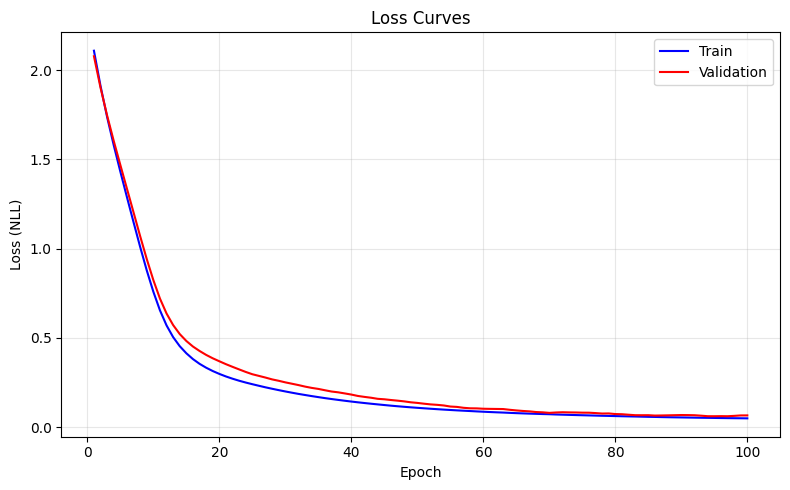

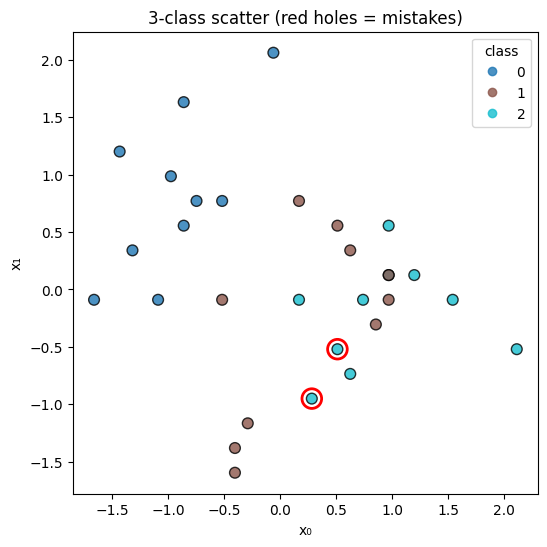

In [31]:
model_c = ClassicalNN(input_dim, hidden_dim=8, output_dim=output_dim, is_multiclass=is_multiclass)
optimizer_c = optim.Adam(model_c.parameters(), lr=0.01)

start_time = time.time()
model_c.fit(train_loader_c, val_loader_c, epochs=epochs, optimizer=optimizer_c, verbose=True)
end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs


test_metrics = model_c.evaluate(test_loader_c)
print(f"Test Results: Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.4f}, F1={test_metrics[4]:.4f}")

model_c.plot_history()

test_loader_c_x = test_loader_c.dataset.tensors[0].numpy()
plot_classification_results(
    test_loader_c_x,
    test_metrics[6],
    test_metrics[5]
)

In [ ]:
# def get_weights_and_biases(model):
#     layer_base_names_in_order = []
#     weights_and_biases = {}
#     for name, module in model.named_modules():
#         if isinstance(module, torch.nn.Linear):
#             weights_and_biases[f"{name}.weight"] = module.weight.detach().cpu().numpy()
#             weights_and_biases[f"{name}.bias"] = module.bias.detach().cpu().numpy()
#             if name not in layer_base_names_in_order:
#                 layer_base_names_in_order.append(name)
#     return weights_and_biases, layer_base_names_in_order

# wandb, layer_base_names_in_order = get_weights_and_biases(model_c)
# for name, tensor in wandb.items():
#     print(f"{name}: {tensor.shape}")

# for name in layer_base_names_in_order:
#     print(name)

fc1.weight: (8, 4)
fc1.bias: (8,)
fc2.weight: (8, 8)
fc2.bias: (8,)
fc3.weight: (3, 8)
fc3.bias: (3,)
fc1
fc2
fc3


In [ ]:
from utils.WeightInformedCircuitDesign import PQCGenerator, ClassicalLayerInfo
from utils.WeightInformedCircuitDesign import get_weights_and_biases

# --- 2. Extract Weights and Biases from the PyTorch Model ---
wandb, layer_base_names_in_order = get_weights_and_biases(model_c)

print("Extracted Classical Weights and Biases from PyTorch Model:")
for name, tensor in wandb.items():
    print(f"{name}: {tensor.shape}")
print("-" * 30)

# --- 3. Prepare ClassicalLayerInfo List in Order ---
classical_layers_info = []
# For your ClassicalNN, the layers are named 'fc1', 'fc2'
# Define the order of linear layers as they appear in your model's forward pass
# These are the *base names* of the attributes in your ClassicalNN class
for layer_base_name in layer_base_names_in_order:
    weight_key = f"{layer_base_name}.weight"
    bias_key = f"{layer_base_name}.bias"
    if weight_key in wandb and bias_key in wandb:
        classical_layers_info.append(
            ClassicalLayerInfo(
                weights=wandb[weight_key],
                biases=wandb[bias_key],
                name=layer_base_name
            )
        )
    else:
        print(f"Warning: Could not find weights/biases for layer base name '{layer_base_name}'. "
                f"Expected keys: {weight_key}, {bias_key}. Found in wandb: {list(wandb.keys())}")

if not classical_layers_info:
    raise ValueError("No classical layer information was extracted. Check PyTorch model structure and layer naming.")
if len(classical_layers_info) < 2:
    print(f"Warning: Only {len(classical_layers_info)} classical linear layer(s) processed. "
            "At least 2 are needed to form a PQC block with the current strategy.")

# print("\nProcessed Classical Layers for PQC:")
# for i, layer in enumerate(classical_layers_info):
#     print(f"Layer {i} ({layer.name}): Weights {layer.weights.shape}, Biases {layer.biases.shape}, In: {layer.in_features}, Out: {layer.out_features}")
# print("-" * 30)

n_qubits_for_pqc = classical_layers_info[0].in_features
pqc_gen = PQCGenerator(n_qubits=n_qubits_for_pqc, angle_scale_factor=0.1)
num_pqc_blocks = len(classical_layers_info) - 1 

if num_pqc_blocks < 1:
    print("Not enough classical layers to form any PQC blocks with the current strategy.")
else:
    for i in range(num_pqc_blocks):
        current_classical_layer = classical_layers_info[i]
        next_classical_layer = classical_layers_info[i+1]
        pqc_gen.add_pqc_block(current_classical_layer, next_classical_layer, block_index=i+1)

circuit_drawing = pqc_gen.draw()
if circuit_drawing:
    print(circuit_drawing)

# --- Accessing Trainable Parameters and Initial Values ---
trainable_params, initial_values_dict = pqc_gen.get_trainable_parameters_with_initial_values()

print(f"\nNumber of trainable parameters: {len(trainable_params)}")
# print("Trainable Parameters and their Initial Values:")
# for param, value in initial_values_dict.items():
#     print(f"{param.name}: {value:.6f}")

# Example: Convert initial_values_dict to a list of values in the order of trainable_params
# This is often needed for optimizers.
initial_point = [initial_values_dict[param] for param in trainable_params]
# print("\nInitial point (list of values for optimizers):")
# print(np.array(initial_point))


In [36]:
# dataset_name = "wine" # "iris", "wine", "diabetes"

# openml_dataset_ids = {
#     "iris": 61,
#     "wine": 187,
#     "diabetes": 37,
# }

# openml_dataset_id = openml_dataset_ids[dataset_name] 
# do_pca = True
# n_components = 2

# batch_size = 32
# epochs = 100

# classical_data, quantum_data, input_dim, output_dim, is_multiclass = data_pipeline(openml_dataset_id, batch_size=batch_size, do_pca=do_pca, n_components=n_components)
# x_train_c, x_val_c, x_test_c, y_train_c, y_val_c, y_test_c, train_loader_c, val_loader_c, test_loader_c = classical_data
# x_train_q, x_val_q, x_test_q, y_train_q, y_val_q, y_test_q, train_loader_q, val_loader_q, test_loader_q = quantum_data

# # get class balances
# print_class_distribution(y_train_c, "Train")
# print_class_distribution(y_val_c, "Validation")
# print_class_distribution(y_test_c, "Test")


In [37]:
# model_q = SamplerQNNTorchModel(n_qubits=input_dim, depth=4, num_classes=output_dim)
# optimizer_q = optim.Adam(model_q.parameters(), lr=0.05)
# # optimizer_q = torch.optim.SGD(model_q.parameters(), lr=0.01, momentum=0.9)
# scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_q,
#     mode      = "min",       
#     factor    = 0.3,          
#     patience  = epochs//5,       
#     min_lr    = 1e-4,        
#     verbose   = True,
# )

# start_time = time.time()
# model_q.fit(train_loader_q, val_loader_q, epochs=epochs, optimizer=optimizer_q, scheduler=scheduler_q)
# end_time = time.time()  

# test_metrics = model_q.evaluate(test_loader_q)
# print(f"Test Results: Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.4f}, F1={test_metrics[4]:.4f}")

# model_q.plot_history()

# test_loader_q_x = test_loader_q.dataset.tensors[0].numpy()
# plot_classification_results(
#     test_loader_q_x,
#     test_metrics[6],
#     test_metrics[5]
# )

In [38]:
# model_c = ClassicalNN(input_dim, hidden_dim=32, output_dim=output_dim, is_multiclass=is_multiclass)
# optimizer_c = optim.Adam(model_c.parameters(), lr=0.01)

# start_time = time.time()
# model_c.fit(train_loader_c, val_loader_c, epochs=epochs, optimizer=optimizer_c, verbose=True)
# end_time = time.time()
# average_time_per_epoch = (end_time - start_time) / epochs


# test_metrics = model_c.evaluate(test_loader_c)
# print(f"Test Results: Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.4f}, F1={test_metrics[4]:.4f}")

# model_c.plot_history()

# test_loader_c_x = test_loader_c.dataset.tensors[0].numpy()
# plot_classification_results(
#     test_loader_c_x,
#     test_metrics[6],
#     test_metrics[5]
# )

# results_exporter(
#     model_c,
#     model_type="classical",
#     dataset_name=dataset_name,
#     batch_size=batch_size,
#     epochs=epochs,
#     average_time_per_epoch=average_time_per_epoch,
#     input_dim=input_dim,
#     depth=0,
#     num_classes=output_dim,
#     test_metrics={
#         "test_acc": test_metrics[1],
#         "test_loss": test_metrics[0]
#     }
# )